In [1]:
################
################   Clean Data + join Data + Generate Model + Evaluate
################   Telstra Network Disruptions Kaggle Competition
################

import warnings; warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import seaborn as sns
from sklearn import preprocessing
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import KFold
from sklearn.cross_validation import train_test_split
from scipy import stats

# import other methods
from clean import *


In [2]:
%matplotlib inline

In [3]:
# read the data
event = pd.read_csv("../../../github_data/telstradisr_data/event_type.csv")
log = pd.read_csv("../../../github_data/telstradisr_data/log_feature.csv")
sample = pd.read_csv("../../../github_data/telstradisr_data/sample_submission.csv")
severity = pd.read_csv("../../../github_data/telstradisr_data/severity_type.csv")
resource = pd.read_csv("../../../github_data/telstradisr_data/resource_type.csv")
train = pd.read_csv("../../../github_data/telstradisr_data/train.csv")
test = pd.read_csv("../../../github_data/telstradisr_data/test.csv")

In [4]:
# obtain integers out of strings with redundant data
event['event_type'] = event['event_type'].str.split(' ').str[1]
log['log_feature'] = log['log_feature'].str.split(' ').str[1]
severity['severity_type'] = severity['severity_type'].str.split(' ').str[1]
resource['resource_type'] = resource['resource_type'].str.split(' ').str[1]
test['location'] = test['location'].str.split(' ').str[1]
train['location'] = train['location'].str.split(' ').str[1]

In [5]:
# check in each log table if ids repeated
tables = [log,event,severity,resource] 
names = ['log','event','severity','resource'] 
for i in range(len(tables)):
    check = unique_column(tables[i],tables[i].columns[-1])
    
    # AGGREGATE CATEGORICAL VALUES INTO A DICTIO
    if check == False:
        if len(tables[i].columns) == 2:
            a = tables[i].groupby([tables[i].columns[-2],tables[i].columns[-1]]).agg({tables[i].columns[-1]:'count'})
            a.index.names = ['id','cat']
            a = a.reset_index()
            a = a.set_index('cat')
            
            # check if any value is greater than 1
            #l1 = a[tables[i].columns[-1]]
            #l3 = a[tables[i].columns[-2]]
            #for i in range(len(l1)):
            #    if l3.iloc[i] != 1:
            #        print('more than once',l3.iloc[i])
                    
            # take care that keys are still integers in the dict            
            a = a.groupby('id').apply(lambda x: {int(k):int(v) for k,v in x.to_dict()[tables[i].columns[-1]].items()})
            tables[i] = pd.DataFrame(a,columns=[tables[i].columns[-1]])
            
        elif len(tables[i].columns) == 3:
            a = tables[i].groupby([tables[i].columns[-3],tables[i].columns[-2],tables[i].columns[-1]]).agg({tables[i].columns[-1]:'count',tables[i].columns[-2]:'count'})
            a.index.names = ['id','cat1','cat2']
            a = a.reset_index()
            a = a.set_index('cat1')
            b = a.set_index('cat2')
            
            # check if any value is greater than 1
            #l1 = a[tables[i].columns[-1]]
            #l2 = a[tables[i].columns[-3]]
            #l3 = a[tables[i].columns[-2]]
            #print(l1,l2,l3)
            #for i in range(len(l1)):
            #    if l1.iloc[i] != 1:
            #        print('more than once',l2.iloc[i])
            #for i in range(len(l3)):
            #    if l3.iloc[i] != 1:
            #        print('more than once',l2.iloc[i])
        
            # take care that keys are still integers in the dict
            a = a.groupby('id').apply(lambda x: {int(k):int(v) for k,v in x.to_dict()[tables[i].columns[-1]].items()})
            b = b.groupby('id').apply(lambda x: {int(k):int(v) for k,v in x.to_dict()[tables[i].columns[-2]].items()})
            log1 = pd.DataFrame(a,columns=[tables[i].columns[-1]])
            log2 = pd.DataFrame(b,columns=[tables[i].columns[-2]])
event = tables[1]
severity = tables[2]
resource = tables[3]

In [6]:
log1.head()

,volume
id,
1,"{345: 1, 179: 1, 68: 1}"
2,"{312: 1, 313: 1, 235: 1, 315: 1, 233: 1}"
3,{171: 1}
4,{370: 1}
5,"{312: 1, 232: 1}"


In [7]:
event.head()

,event_type
id,
1,"{11: 1, 13: 1}"
2,"{34: 1, 35: 1}"
3,{11: 1}
4,{47: 1}
5,"{34: 1, 35: 1}"


In [8]:
# join tables with train data 
train = train.merge(event, left_on='id', right_index=True, how='left')
train = train.merge(severity, left_on='id', right_index=True, how='left')
train = train.merge(resource, left_on='id', right_index=True, how='left')
train = train.merge(log1, left_on='id', right_index=True, how='left')
train = train.merge(log2, left_on='id', right_index=True, how='left')
train.head()

,id,location,fault_severity,event_type,severity_type,resource_type,volume,log_feature
0,14121,118,1,"{34: 1, 35: 1}",{2: 1},{2: 1},"{312: 1, 232: 1}",{19: 1}
1,9320,91,0,"{34: 1, 35: 1}",{2: 1},{2: 1},"{315: 1, 235: 1}","{200: 1, 116: 1}"
2,14394,152,1,"{34: 1, 35: 1}",{2: 1},{2: 1},"{221: 1, 301: 1}",{1: 1}
3,8218,931,1,"{11: 1, 15: 1}",{1: 1},{8: 1},"{80: 1, 82: 1, 203: 1}","{1: 1, 12: 1, 9: 1}"
4,14804,120,0,"{20: 1, 34: 1, 11: 1, 36: 1}",{1: 1},"{8: 1, 2: 1}","{160: 1, 227: 1, 117: 1, 134: 1, 232: 1, 219: ...","{1: 1, 2: 1}"


In [9]:
# join tables with test data
test = test.merge(event, left_on='id', right_index=True, how='left')
test = test.merge(severity, left_on='id', right_index=True, how='left')
test = test.merge(resource, left_on='id', right_index=True, how='left')
test = test.merge(log1, left_on='id', right_index=True, how='left')
test = test.merge(log2, left_on='id', right_index=True, how='left')
test.head()

,id,location,event_type,severity_type,resource_type,volume,log_feature
0,11066,481,"{34: 1, 35: 1}",{2: 1},{2: 1},"{308: 1, 228: 1, 230: 1, 310: 1}","{24: 1, 20: 1, 26: 1, 28: 1}"
1,18000,962,"{11: 1, 15: 1}",{1: 1},{8: 1},"{82: 1, 203: 1}","{9: 1, 20: 1}"
2,16964,491,"{34: 1, 35: 1}",{2: 1},{2: 1},"{315: 1, 235: 1}","{10: 1, 11: 1}"
3,4795,532,"{10: 1, 27: 1}",{5: 1},"{9: 1, 3: 1}","{240: 1, 37: 1, 38: 1}",{1: 1}
4,3392,600,{15: 1},{2: 1},{8: 1},"{82: 1, 203: 1}","{2: 1, 6: 1}"


In [10]:
##### split data  
tr_a, te_a = train_test_split(train, train_size = 0.8)

## define variables 
y_train = tr_a.fault_severity
y_test = te_a.fault_severity
columns = train.columns
x_train = tr_a[columns[3:]]
x_test = te_a[columns[3:]]

In [11]:
## check if null values
tr_a.isnull().sum()
te_a.isnull().sum()
test.isnull().sum()

id               0
location         0
event_type       0
severity_type    0
resource_type    0
volume           0
log_feature      0
dtype: int64

In [12]:
## check if nan values
nantr = ifNaN(x_train)
nante = ifNaN(x_test)
print(nantr,nante)

False False


In [13]:
x_train.head()

,event_type,severity_type,resource_type,volume,log_feature
2442,"{11: 1, 15: 1}",{1: 1},{8: 1},{82: 1},{10: 1}
3175,{11: 1},{1: 1},{8: 1},"{73: 1, 195: 1}",{1: 1}
2335,"{34: 1, 35: 1}",{2: 1},{2: 1},"{312: 1, 232: 1}","{1: 1, 3: 1}"
5156,"{3: 1, 11: 1}",{1: 1},{8: 1},"{191: 1, 140: 1, 171: 1, 70: 1, 55: 1}","{1: 1, 10: 1, 13: 1}"
6135,"{34: 1, 35: 1}",{2: 1},{2: 1},"{228: 1, 230: 1, 232: 1, 233: 1, 235: 1, 308: ...","{1: 1, 2: 1, 20: 1, 21: 1, 24: 1, 25: 1}"


In [14]:
x_test.head()

,event_type,severity_type,resource_type,volume,log_feature
3565,"{20: 1, 23: 1, 24: 1, 11: 1, 13: 1, 14: 1}",{1: 1},"{8: 1, 2: 1, 4: 1, 6: 1, 7: 1}","{273: 1, 306: 1, 219: 1, 53: 1, 54: 1, 134: 1,...","{1: 1, 2: 1, 3: 1, 4: 1, 9: 1}"
358,{11: 1},{2: 1},{8: 1},"{209: 1, 87: 1}",{2: 1}
760,{11: 1},{1: 1},{8: 1},"{170: 1, 54: 1}","{2: 1, 4: 1}"
1227,{15: 1},{2: 1},{8: 1},"{80: 1, 82: 1, 203: 1}","{2: 1, 4: 1, 5: 1}"
1405,"{11: 1, 15: 1}",{1: 1},{8: 1},"{56: 1, 172: 1}","{2: 1, 3: 1}"


In [15]:
x_train.shape

(5904, 5)

In [16]:
##### generate pipeline 
## shape 5904x615
call = PipelineTelstra(RandomForestClassifier)
call.set_params()
call = call.fit(x_train,y_train)

pipeline done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.


In [17]:
##### generate y_predict
y_predict = call.predict(x_test)

DataSpliterTrans transform done.
DataSpliterTrans transform done.
DataSpliterTrans transform done.
DataSpliterTrans transform done.
DataSpliterTrans transform done.


In [18]:
##### first evaluation confusion matrix
cm1 = confusion_matrix(y_test,y_predict)
cm1

array([[807, 110,  27],
       [171, 198,  20],
       [ 43,  35,  66]])

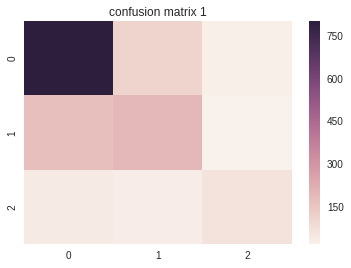

In [19]:
ax = sns.heatmap(cm1)
ax.set_title('confusion matrix 1')

In [ ]:
## save confusion matrix 1
fig = ax.get_figure()
fig.savefig("cm1_preCV.png")

In [22]:
##### cross validation 3 folds
kf = KFold(5904, n_folds=3)
itr = defaultdict(list)
ite = defaultdict(list)
c = 0
for trai, tes in kf:
    print("%s %s" % (trai, tes))
    itr[c] = trai
    ite[c] = tes
    c += 1

[1968 1969 1970 ..., 5901 5902 5903] [   0    1    2 ..., 1965 1966 1967]
[   0    1    2 ..., 5901 5902 5903] [1968 1969 1970 ..., 3933 3934 3935]
[   0    1    2 ..., 3933 3934 3935] [3936 3937 3938 ..., 5901 5902 5903]


In [23]:
##### redefine my samples

#### 2.1 samples
x_train1 = x_train.iloc[itr[0],:]
x_test1 = x_train.iloc[ite[0],:]
y_train1 = tr_a.fault_severity.iloc[itr[0]]
y_test1 = tr_a.fault_severity.iloc[ite[0]]

In [24]:
#### 2.1 make prediction
call = PipelineTelstra(RandomForestClassifier)
call = call.fit(x_train1,y_train1)

pipeline done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.


In [25]:
y_predict1 = call.predict(x_test1)

DataSpliterTrans transform done.
DataSpliterTrans transform done.
DataSpliterTrans transform done.
DataSpliterTrans transform done.
DataSpliterTrans transform done.


In [26]:
#### 2.1 confusion matrix
cm21 = confusion_matrix(y_test1,y_predict1)
cm21

array([[1094,  143,   46],
       [ 248,  230,   27],
       [  55,   46,   79]])

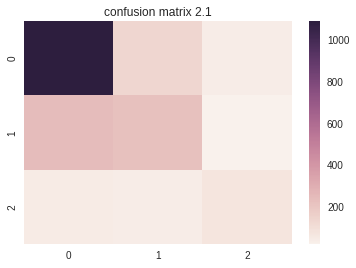

In [27]:
ax = sns.heatmap(cm21)
ax.set_title('confusion matrix 2.1')

In [28]:
fig = ax.get_figure()
fig.savefig("cm21_posCV.png")

In [ ]:
#### 2.2 samples
x_train2 = x_train.iloc[itr[1],:]
x_test2 = x_train.iloc[ite[1],:]
y_train2 = tr_a.target.iloc[itr[1]]
y_test2 = tr_a.target.iloc[ite[1]]

In [ ]:
#### 2.2 make prediction
call = PipelineTelstra(RandomForestClassifier)
call = call.fit(x_train2,y_train2)

In [ ]:
y_predict2 = call.predict(x_test2)

In [ ]:
#### 2.2 confusion matrix
cm22 = confusion_matrix(y_test2,y_predict2)
cm22

In [ ]:
ax = sns.heatmap(cm22)
ax.set_title('confusion matrix 2.2')

In [ ]:
fig = ax.get_figure()
fig.savefig("cm22_posCV.png")

In [ ]:
#### 2.3 samples
x_train3 = x_train.iloc[itr[2],:]
x_test3 = x_train.iloc[ite[2],:]
y_train3 = tr_a.target.iloc[itr[2]]
y_test3 = tr_a.target.iloc[ite[2]]

In [ ]:
#### 2.3 make prediction
call = PipelineTelstra(RandomForestClassifier)
call = call.fit(x_train3,y_train3)

In [ ]:
y_predict3 = call.predict(x_test3)

In [ ]:
#### 2.3 confusion matrix
cm23 = confusion_matrix(y_test3,y_predict3)
cm23

In [ ]:
ax = sns.heatmap(cm23)
ax.set_title('confusion matrix 2.3')

In [ ]:
fig = ax.get_figure()
fig.savefig("cm23_posCV.png")